### Deep Mutational Scanning of Illumina Amplicon Sequencing Data

This notebook starts from one or more **Illumina amplicon sequencing datasets**, consisting of paired-end **FASTQ files** (forward reads: R1, reverse reads: R2).

To begin processing, run the script `0_Illumina_preprocess_and_align_reads.py`, which performs:
1. **Demultiplexing** and **quality filtering** of reads
2. **Alignment** of reads to the reference sequence using `blastn`

For more details, see the `README.md` file in this repository.

The full downstream analysis is also automated in the script `1_Illumina_analyze_mutation_enrichment.py`.

---

#### This notebook includes the following steps:
- Detection of insertions and deletions  
- Calculation of mutation enrichment across the sequence  
- Computation of per-position mutation rates  
- Analysis of the mutational spectrum  
- Visualizations of the above results


---


### Notebook Setup

In [ ]:
# --- Import necessary modules ---
import os
import sys
os.chdir("..")
import json
import pickle as pkl
from importlib import reload
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
import scipy
from Bio import SeqIO
from Bio.SeqIO import QualityIO
from utils import dna_rev_comp, translate_dna2aa
from scripts.preprocessing_functions import *
from scripts.plotting import *
from scripts.Illumina_functions import *
from scripts.linker_analysis_functions import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

# ======================== PLOTTING SETTINGS ========================

# --- Custom color map for mutation visualization ---
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
], N=256)

# --- Seaborn theme configuration ---
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 1
}
sns.set_theme(context="paper", style='ticks', palette="Greys_r", rc=custom_params)

# --- General matplotlib settings ---
fs = 8  # font size
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({
    'font.family': 'Avenir Next',
    'font.weight': 'demi', 
    'font.size': fs,
    'text.color': '#231F20',
    'axes.labelcolor': '#231F20',
    'xtick.color': '#231F20',
    'ytick.color': '#231F20',
    'axes.edgecolor': '#231F20',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'pdf.fonttype': 42,
    'text.usetex': False
})
sns.set_context("paper", rc={
    "font.size": fs,
    "axes.titlesize": fs + 1,
    "axes.labelsize": fs,
    "axes.linewidth": 1,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "legend.title_fontsize": fs + 1
})

# ======================== LAYOUT PARAMETERS ========================

# --- Pre-defined figure dimensions for multi-panel plots ---
hi = 10.5 * 0.75
wi3 = 2.24
wi2 = 4.76
wi1 = 7.24
nr = 5

# --- Utility for shortening sample names ---
short_fn = np.vectorize(lambda x: x[:5])

### Load and organize BLAST alignment results

In [2]:
# ======================== ANALYSIS PARAMETERS ========================

# --- Path to input FASTQ files and config ---
homedir =  "data/Illumina/P02_RL8_LOV2" 

Bc = "BC1" # Barcode to be analyzed (must match one used during demultiplexing)
read_dirs = ["R1", "R2"] # Read directions to include in the analysis
Section = "S1" # Section/amplicon to be analyzed
data_type = "AA" # Mutation type: "AA" = amino acids, "Nt" = nucleotides


all_alignments = {}

# --- Sequence region of interest ---
LOV_startseq = "ttagccacaa".upper()
LOV_endseq = "cggccaaa".upper()

# --- Load variant information from config ---
with open(f"{homedir}/config.json") as f:
  config = json.load(f)

variant = config["variant"]

# --- Output folder for storing figures and results generated by the notebook ---
FigFolder = f"{os.getcwd()}/final_output/{variant}_w_nb/"
if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)

In [3]:
# ====================== LOAD AND FILTER BLAST ALIGNMENTS ======================

# --- Container to store parsed alignment and coverage data for each read direction ---
all_alignments = {}
all_coverages = {}

# --- Specify the data type to be analyzed (e.g., "AA" for amino acids) ---
data_type = "AA"

# --- Loop through both read directions: R1 and R2 ---
for read_dir in read_dirs:

    # --- Load BLAST output JSON file ---
    print("################",  read_dir,   "################")
    with open(f"{homedir}/blast/alignments/{variant}_{Bc}_{Section}_Nt_filt_{read_dir}.out", "r") as file:
        blast_output = json.load(file)

    # --- Load the reference DNA sequence ---
    amplicon_seq = str(SeqIO.read(f"{homedir}/references/{variant}_{Bc}_{Section}_Nt_filt_ref.fasta", "fasta").seq)
    
    # --- Translate DNA reference to amino acid sequence if needed ---
    amplicon_AA = translate_dna2aa(amplicon_seq)

    # --- Extract BLAST hits from the loaded JSON ---
    blast_alignments = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()
    
    # --- Define start and end indices of the LOV2 region within the DNA reference ---
    LOV2_startidx = amplicon_seq.index(LOV_startseq)
    LOV2_endidx = amplicon_seq.index(LOV_endseq) + len(LOV_endseq)
    print(len(blast_alignments), "alignments before filtering for LOV2 insertion site")

    # --- Filter BLAST hits: keep only those that span the LOV2 region with a ±10 nt margin ---
    filter_for_region = LOV2_startidx if read_dir=="R1" else LOV2_endidx 

    blast_alignments = [alignment for alignment in blast_alignments if alignment["hsps"][0]["query_from"] <= filter_for_region-10 and alignment["hsps"][0]["query_to"] >= filter_for_region+10]
    print(len(blast_alignments), "alignments after filtering for LOV2 insertion site")

    # --- Parse and restructure alignments to extract aligned sequences and coverage data ---
    alignments, coverages = restructure_alignments(blast_alignments, query_seq=amplicon_seq, read_dir=read_dir)
    
    # --- Store the results per read direction ---
    all_alignments[read_dir] = alignments
    all_coverages[read_dir] = coverages

################ R1 ################
39192 alignments before filtering for LOV2 insertion site
27038 alignments after filtering for LOV2 insertion site
80 sequences are excluded, since they do not cover the start (R1) or end (R2) of the amplicon sequence.
################ R2 ################
37017 alignments before filtering for LOV2 insertion site
23581 alignments after filtering for LOV2 insertion site
61 sequences are excluded, since they do not cover the start (R1) or end (R2) of the amplicon sequence.


### Analyze BLAST alignments  
Note: this analysis is also fully automated when running `2_Illumina_analyze_mutation_enrichment.py`

In [4]:
# ====================== CHARACTERIZE MUTATIONAL ENRICHMENTS ======================

# --- Container for enrichment results from both read directions ---
all_enrichments = {"R1":{}, "R2":{}}

# --- Loop through each read direction (R1 and R2) ---
for read_dir in read_dirs: 

    # --- Analyze alignments: get all variant calls, indels, and enrichment metrics ---
    all_variants, indels,  enrichment_counts, enrichment_relative = characterize_DMS_blast_alignment(all_alignments[read_dir], amplicon_seq, data_type=data_type,read_dir=read_dir, exclude_not_covered_regions=False)
   
    # --- Store results in a structured dictionary ---
    all_enrichments[read_dir]["all_variants"] = pd.DataFrame.from_dict(all_variants)
    all_enrichments[read_dir]["indels"] = indels
    all_enrichments[read_dir]["enrichment_counts"] = enrichment_counts
    all_enrichments[read_dir]["enrichment_relative"] = enrichment_relative

# ====================== COMBINE R1 AND R2 ENRICHMENTS ======================

# --- Set correct reference depending on analysis type ---
reference = amplicon_AA if data_type == "AA" else amplicon_seq

# --- Combine variant counts from R1 and R2 ---
total_variants = all_enrichments[read_dirs[0]]["all_variants"] + all_enrichments[read_dirs[1]]["all_variants"]

# --- Combine enrichment counts (mutations over wild type) ---
total_enrichment = all_enrichments[read_dirs[0]]["enrichment_counts"] + all_enrichments[read_dirs[1]]["enrichment_counts"]

# --- Calculate relative enrichment (mutation frequency per position) ---
total_relative_enrichment = total_enrichment/total_variants.sum()

# ====================== COMBINE INDELS ======================

# --- Sum indel counts from both read directions ---
total_indels = all_enrichments[read_dirs[0]]["indels"] + all_enrichments[read_dirs[1]]["indels"]

# --- Calculate indel frequency using total raw coverage before filtering ---
total_indels_freq = total_indels/(all_coverages[read_dirs[0]]+all_coverages[read_dirs[1]]) # here, we use the coverage calculated before indel reads were filtered out

# ====================== MASK LOW-COVERAGE POSITIONS ======================

# --- Get total coverage per position ---
enrichment_coverages = total_variants.sum()

# --- Set enrichment values to NaN for positions with coverage below threshold (e.g. 2000 reads) ---
total_relative_enrichment.loc[:,enrichment_coverages < 2000] = np.nan

675 sequences with off target indels are excluded
26283 sequences are included in the enrichment analysis
943 sequences with off target indels are excluded
22577 sequences are included in the enrichment analysis


### Plot mutation enrichment heatmap

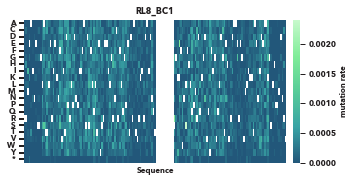

In [5]:
plot_mutation_enrichment(total_relative_enrichment, 
                         ref_seq=reference, 
                         samplename=f"{variant}_{Bc}", 
                         data_type="AA", 
                         FigFolder=FigFolder, 
                         vmax=None, 
                         cmap = custom_cmap)

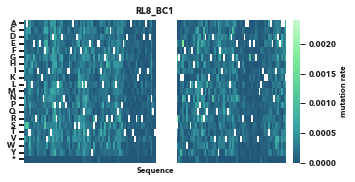

In [6]:
# ====================== OPTIONAL: FILTER TO REGION OF INTEREST (ROI) ======================

# --- Determine start and end indices for the region of interest ---
# For DNA: use nucleotide indices; for AA: divide by 3 to get codon/amino acid position
roi_startidx = LOV2_startidx if data_type == "DNA" else LOV2_startidx//3
roi_endidx = LOV2_endidx if data_type == "DNA" else LOV2_endidx//3

# --- Slice the enrichment matrix to keep only the ROI columns ---
total_relative_enrichment_roi = total_relative_enrichment.iloc[:,roi_startidx:roi_endidx]

plot_mutation_enrichment(total_relative_enrichment_roi, 
                         ref_seq=reference[roi_startidx:roi_endidx], 
                         samplename=f"{variant}_{Bc}", 
                         data_type="AA", 
                         FigFolder=FigFolder, 
                         vmax=None, 
                         cmap = custom_cmap)

### Plot INDEL frequencies

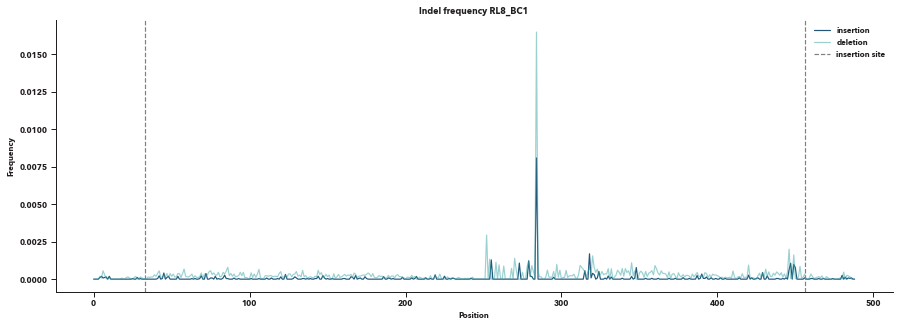

In [7]:
# --- Plot the frequency of insertions and deletions across the sequence ---
# This function highlights the region of interest (LOV2) using two different colors
plot_indel_freqs(
    total_indels_freq,                                # y-values: indel frequency per position
    filename=f"{variant}_{Bc}",                       # output name
    FigFolder=FigFolder,                              # folder to save the plot
    roi_start_idx=LOV2_startidx,                      # start index of region of interest
    roi_end_idx=LOV2_endidx,                          # end index of region of interest
    color1="#22577A",                                 # main bar color (e.g. conserved region)
    color2="#38A3A5"                                   # highlight color (e.g. variable region / ROI)
)

# --- Display the plot inline (for notebook or script with live output) ---
plt.show()

### Calculate and plot mutational spectrum

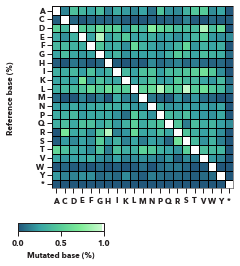

In [8]:
# --- Fill NaN values with 0 for downstream calculations ---
# NaNs typically come from positions filtered out due to low coverage
total_relative_enrichment.fillna(0, inplace=True)

# --- Compute the mutational spectrum from the enrichment matrix ---
# `x` = absolute counts (optional), `y` = percentage-based mutation spectrum
x, y = calc_mut_spectrum_from_enrichment(
    total_relative_enrichment,
    ref_seq=reference,
    data_type="AA"
)

# --- Plot the mutational spectrum as a barplot or heatmap depending on implementation ---
plot_mutation_spectrum(
    y,
    data_type="AA",
    colormap=custom_cmap  # Use custom colormap for consistent styling
)

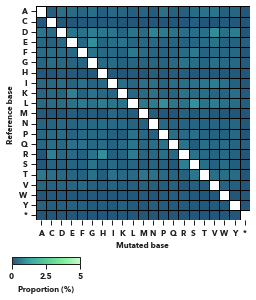

In [12]:
# ====================== PLOT MUTAGENIC SPECTRUM HEATMAP (ANNOTATED ROWS) ======================

fig, ax = plt.subplots(figsize=(wi2, hi/2))
fig.subplots_adjust(wspace=0.01)

# --- Draw the main mutational spectrum heatmap ---
sns.heatmap(
    y,                                # mutation spectrum (%)
    annot=False,
    linecolor="black",
    cmap=custom_cmap,
    xticklabels=True,
    yticklabels=True,
    ax=ax,
    cbar=False,
    linewidths=0.5,
    square=True,
    vmin=0,
    vmax=5
)

ax.set_xlabel('Mutated base')
ax.set_ylabel('Reference base')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# --- Add horizontal colorbar manually ---
cbar_ax = fig.add_axes([0.13, -0.03, 0.2, 0.025])
cbar = fig.colorbar(ax.collections[0], cax=cbar_ax, orientation="horizontal", extend='neither')
cbar.set_ticks([0, 2.5, 5])
cbar.ax.set_xticklabels([0, 2.5, 5])
cbar.set_label("Proportion (%)", fontsize=8)
cbar.ax.tick_params(labelsize=8)

# --- Save and show ---
plt.savefig(f"{FigFolder}/AAs_mutagenic_spectrum_roi_perc_ordered_Annot.pdf", bbox_inches="tight")
plt.savefig(f"{FigFolder}/AAs_mutagenic_spectrum_roi_perc_ordered_Annot.png", bbox_inches="tight")
plt.show()

### Plot the coverage

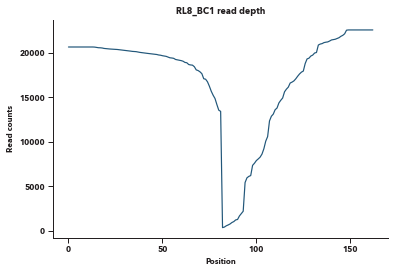

In [ ]:
coverage_plot(total_variants.sum(), 
              FigFolder=FigFolder, 
              samplename = f"{variant}_{Bc}", 
              color = "#22577A")

### Specific analysis: Comparison of DP6 and RL8

In [ ]:
# ====================== LOAD INDEL AND MUTATION DATA ======================

# --- Load indel frequency data (DNA-level, unfiltered ROI) ---
DP6_indels = pd.read_csv(
    "final_output/DP6/combined/enrichments/DNA/DP6_BC1_S1_combined_roiFalse_DNA_indel_freq.csv",
    index_col=0
)
RL8_indels = pd.read_csv(
    "final_output/RL8/combined/enrichments/DNA/RL8_BC1_S1_combined_roiFalse_DNA_indel_freq.csv",
    index_col=0
)

# --- Load AA-level enrichment data (ROI-filtered) ---
RL8_mutations = pd.read_csv(
    "final_output/RL8/combined/enrichments/AA/RL8_BC1_S1_combined_roiTrue_AA_enrichment_relative.csv",
    index_col=0
)
DP6_mutations = pd.read_csv(
    "final_output/DP6/combined/enrichments/AA/DP6_BC1_S1_combined_roiTrue_AA_enrichment_relative.csv",
    index_col=0
)

# --- Drop positions with missing data from indel matrices ---
DP6_indels.dropna(axis=1, how="any", inplace=True)
RL8_indels.dropna(axis=1, how="any", inplace=True)

# ====================== SLICE INDEL TYPES AND SUM MUTATION FREQUENCIES ======================

# --- Extract insertion and deletion rows separately ---
DP6_insertions = DP6_indels.loc["insertion", :]
RL8_insertions = RL8_indels.loc["insertion", :]
DP6_deletions = DP6_indels.loc["deletion", :]
RL8_deletions = RL8_indels.loc["deletion", :]

# --- Compute total mutation frequencies (sum across positions) ---
DP6_muts = DP6_mutations.sum()
RL8_muts = RL8_mutations.sum()

# ====================== DEFINE COLOR SCHEME FOR PLOTTING ======================

color_DP6 = "#22577A"     # dark blue for DP6
color_RL8 = "#57CC99"     # medium green for RL8
median_color = "black"    # black for medians or reference

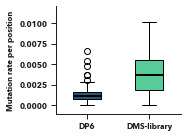

In [ ]:
# ====================== MUTATION RATE PER POSITION ======================

plt.figure(figsize=(wi3, hi / 4))

# --- Plot boxplots of per-position mutation rates for DP6 and RL8 ---
bp = plt.boxplot(
    [DP6_muts, RL8_muts],                # y-values for each group
    tick_labels=["DP6", "DMS-library"],  # x-axis labels
    showfliers=True,                     # show outliers
    patch_artist=True,                   # allows coloring boxes
    widths=0.45,
    positions=[1, 2]                     # manually position boxes for spacing
)

# --- Label y-axis ---
plt.ylabel("Mutation rate per position")

# --- Set y-axis range ---
plt.ylim(-0.001, 0.012) 

# --- Apply custom colors to boxplots ---
for box, color in zip(bp['boxes'], [color_DP6, color_RL8]):
    box.set(facecolor=color)

# --- Customize median lines ---
for median in bp['medians']:
    median.set(color=median_color, linewidth=2)

# --- Save plot to file ---
plt.savefig('final_output/DP6_vs_RL8_mutationrate_per_pos_boxplot.pdf', bbox_inches='tight')

# --- Display the plot inline ---
plt.show()

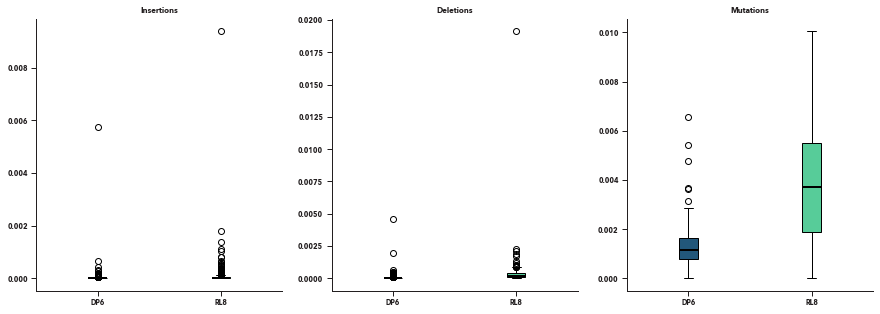

In [ ]:
# ====================== INSERTIONS, DELETIONS, MUTATIONS ======================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# --- Plot insertions ---
bp1 = axes[0].boxplot([DP6_insertions, RL8_insertions], tick_labels=["DP6", "RL8"], 
                       showfliers=True, patch_artist=True)
axes[0].set_title("Insertions")

# --- Plot deletions ---
bp2 = axes[1].boxplot([DP6_deletions, RL8_deletions], tick_labels=["DP6", "RL8"], 
                       showfliers=True, patch_artist=True)
axes[1].set_title("Deletions")

# --- Plot mutations ---
bp3 = axes[2].boxplot([DP6_muts, RL8_muts], tick_labels=["DP6", "RL8"], 
                       showfliers=True, patch_artist=True)
axes[2].set_title("Mutations")

# --- Apply color scheme and median styling to all three plots ---
for bp in [bp1, bp2, bp3]:
    for box, color in zip(bp['boxes'], [color_DP6, color_RL8]):
        box.set(facecolor=color) 

    for median in bp['medians']:
        median.set(color=median_color, linewidth=2) 

plt.savefig("final_output/DP6_vs_RL8_mutationrates_indelrates_boxplot.pdf", bbox_inches = "tight", dpi = 600)
plt.savefig("final_output/DP6_vs_RL8_mutationrates_indelrates_boxplot.png", bbox_inches = "tight", dpi = 600)

plt.show()

In [ ]:
# ====================== MUTATION RATE DISTRIBUTIONS ======================

# --- Flatten mutation matrices and remove NaNs ---
# Take all values from DP6 mutation matrix (except last row), flatten into 1D array

all_DP6_mutations = DP6_mutations.iloc[:-1, :].values.flatten()
all_RL8_mutations = RL8_mutations.iloc[:-1, :].values.flatten()

# --- Remove missing values from both arrays ---

all_DP6_mutations = all_DP6_mutations[~np.isnan(all_DP6_mutations)]
all_RL8_mutations = all_RL8_mutations[~np.isnan(all_RL8_mutations)]

# --- Plot mutation boxplot ---

bp = plt.boxplot(
    [all_DP6_mutations, all_RL8_mutations],  # Mutation data for both groups
    tick_labels=["DP6", "DMS-library"],      # X-axis labels
    showfliers=True,                         # Show outliers
    patch_artist=True                        # Allow coloring of boxes
)

plt.title("Mutations")
plt.ylabel("Mutation rate")

# --- Color the boxplots ---
for box, color in zip(bp['boxes'], [color_DP6, color_RL8]):
    box.set(facecolor=color)
for median in bp['medians']:
    median.set(color=median_color, linewidth=2)

plt.show()

### Targeted evaluation of the DMS-library (RL8) – assessment of mutation enrichment in comparison to the original input library


In [ ]:
# ====================== LOAD RL8 DATA AND DEFINE REFERENCE SEQUENCES ======================

RL8_mutations = pd.read_csv("final_output/RL8/combined/enrichments/AA/RL8_BC1_S1_combined_roiFalse_AA_enrichment_relative.csv", index_col=0)
RL8_DNA_mutations = pd.read_csv("final_output/RL8/combined/enrichments/DNA/RL8_BC1_S1_combined_roiFalse_DNA_enrichment_relative.csv", index_col=0)
RL8_encoded_muts = pd.read_csv("final_output/P0111_RetronLib/BC3_R1/blastpipeline/enrichments/BC3_RL_encoded_mutations.csv", index_col=0).T


RL8_observed_ref = "CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG"
## see /home/student/anna/DMS_analysis/data/fastq/P02_RL8_LOV2/references/RL8_BC1_S1_Nt_filt_ref.fasta

RL8_encoded_ref = "CAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGC"
cut_left = RL8_encoded_ref.index("CGCCGCATGGAAGCGATTAA")
cut_right = RL8_encoded_ref.index("TGGATAACCGCGTG") + len("TGGATAACCGCGTG")

In [ ]:
# ====================== PROCESS RL8 DNA MUTATION DATA ======================

# --- Identify columns (positions) that contain only NaN values ---
# These positions likely have very low sequencing coverage and no reliable data
empty_cols = RL8_DNA_mutations.columns[RL8_DNA_mutations.isna().all()]

# --- Calculate the total relative mutation rate at each position ---
RL8_DNA_muts_prop = RL8_DNA_mutations.sum()

# --- Identify and mask the position with the highest mutation rate ---
# This is likely a silent mutation (e.g. a technical artifact or contamination)
mask_max = RL8_DNA_muts_prop.idxmax()
RL8_DNA_muts_prop[mask_max] = np.nan

# --- Normalize mutation proportions across all valid positions ---
RL8_DNA_muts_prop = RL8_DNA_muts_prop/RL8_DNA_muts_prop.sum()

# --- Sum total mutation counts per position (raw, unnormalized) ---
RL8_DNA_mutations_sum = RL8_DNA_mutations.sum()  

# --- Mask problematic positions again (masking is lost after `.sum()` operation) ---
RL8_DNA_mutations_sum[mask_max] = np.nan
RL8_DNA_mutations_sum[empty_cols] = np.nan
RL8_DNA_muts_prop[mask_max] = np.nan
RL8_DNA_muts_prop[empty_cols] = np.nan


In [ ]:
# ====================== PROCESS RL8 ENCODED MUTATIONS ======================


# --- Cut the encoded mutation matrix to match the observed reference frame ---
# Keep only the region between cut_left and cut_right (matching the actual DNA window)
RL8_encoded_muts = RL8_encoded_muts.iloc[:,cut_left:cut_right]

# --- Mask positions with low coverage (same as in the observed DNA mutations) ---
# Identify positions (columns) in the observed data that have only NaN values
empty_cols = RL8_DNA_mutations.columns[RL8_DNA_mutations.isna().all()]
empty_cols = [int(empty_col) for empty_col in empty_cols]

# --- Extract encoded mutation proportions from the first row ---
RL8_encoded_muts_prop = RL8_encoded_muts.iloc[0,:].values

# --- Replace low-coverage positions and the masked maximum with NaN ---
RL8_encoded_muts_prop = pd.DataFrame([RL8_encoded_muts_prop[i] if i not in empty_cols+ [int(mask_max)] else np.nan for i in range(len(RL8_encoded_muts_prop))])


# --- Normalize the encoded mutation profile so that the sum is 1 ---
RL8_encoded_muts_prop = (RL8_encoded_muts_prop/RL8_encoded_muts_prop.sum()).values.flatten()

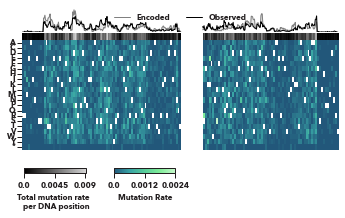

In [ ]:
# ====================== PLOT ENCODED VS OBSERVED MUTATION PROFILES ======================

light_gray = "black"  # Light gray
dark_gray = "#D3D3D3"   # Dark gray

gray_cmap = mcolors.LinearSegmentedColormap.from_list("custom_gray", [light_gray, dark_gray])


fig, axes = plt.subplots(3,1, figsize=(wi*0.8, hi/3), height_ratios=[0.3, 0.08, 1.3])
## put plots closer together
plt.subplots_adjust(hspace=0.01)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)

# --- Plot the encoded mutation profile (gray line) ---
axes[0].plot(RL8_encoded_muts_prop, label = "Encoded", linewidth = 1, color = "grey")

# --- Plot the observed mutation profile (black line) ---
axes[0].plot(RL8_DNA_muts_prop, label = "Observed", linewidth = 1, color = "black")
axes[0].set_xlim(0, len(RL8_encoded_muts.columns))
axes[0].set_ylim(0,0.012)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].legend(frameon = False, ncol=2)
axes[0].fill_between(range(len(RL8_encoded_muts_prop)), RL8_encoded_muts_prop, RL8_DNA_muts_prop, color= "lightgrey", alpha=0.5)

sns.heatmap(pd.DataFrame(RL8_DNA_mutations_sum).T, cmap= gray_cmap, cbar = False, ax = axes[1], xticklabels=False, yticklabels=False)


colors = [
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
]

custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_blue", colors, N=256)
sns.heatmap(RL8_mutations, cmap= custom_cmap, cbar = False, ax = axes[2],yticklabels=True,xticklabels=False)
axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation=0, fontsize = 8)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=1)
axes[2].tick_params(axis='y', pad=2)  
cbar_ax = fig.add_axes([0.13, -0.0, 0.15, 0.03])


cbar = fig.colorbar(axes[1].collections[0], cax=cbar_ax, orientation="horizontal")

ticks_gray = [0.000, 0.0045, 0.009]
cbar.set_ticks(ticks_gray)
cbar.ax.set_xticklabels([0.000, 0.0045, 0.009]) 

cbar.set_label("Total mutation rate  \n per DNA position")

cbar_ax = fig.add_axes([0.35, -0.0, 0.15, 0.03])

cbar = fig.colorbar(axes[2].collections[0], cax=cbar_ax, orientation = "horizontal")
ticks_colored = [0.0, 0.0012, 0.0024]
cbar.set_ticks(ticks_colored)
cbar.ax.set_xticklabels([0.0, 0.0012, 0.0024]) 
cbar.set_label("Mutation Rate")


# plt.savefig("final_output/RL8/RL8_encoded_vs_observed.pdf", bbox_inches='tight')
# plt.savefig("final_output/RL8/RL8_encoded_vs_observed.png", bbox_inches='tight')

plt.show()


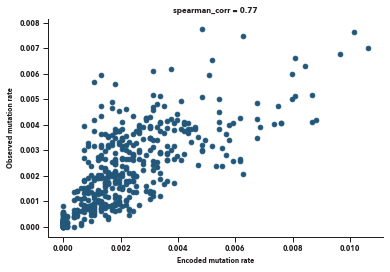

In [ ]:
# ====================== CORRELATION: ENCODED VS OBSERVED MUTATION RATES ======================

# --- Remove missing values (NaNs) from both mutation profiles ---
RL8_DNA_muts_prop = RL8_DNA_muts_prop.dropna()
RL8_encoded_muts_prop = pd.DataFrame(RL8_encoded_muts_prop).dropna()

plt.scatter(RL8_encoded_muts_prop, RL8_DNA_muts_prop, color = "#22577A")

plt.title(f"spearman_corr = {round(scipy.stats.spearmanr(RL8_encoded_muts_prop, RL8_DNA_muts_prop)[0],2)}")
plt.xlabel("Encoded mutation rate")
plt.ylabel("Observed mutation rate")


plt.savefig("final_output/RL8/RL8_encoded_vs_observed_correlation.pdf", bbox_inches='tight')
plt.savefig("final_output/RL8/RL8_encoded_vs_observed_correlation.png", bbox_inches='tight')

### Is RamPhage biased towards codons with single/double/triple base changes? 

In [ ]:
# --- Preferred E. coli codons used for encoding each amino acid in the RL8 retron library ---

ecoli_pref = {
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

In [ ]:
# ====================== LOAD CODON ENRICHMENT COUNTS FOR VARIANT ======================

variant = "RL8"
Folder = f"final_output/{variant}/combined/" 

# --- Load codon enrichment count matrix (per position) ---
# Each column = position; each row = codon
enrichment_counts = pd.read_csv(f"{Folder}/enrichments/Codons/{variant}_BC1_S1_combined_roiTrue_Codons_enrichment_counts.csv", index_col = 0)
FigFolder = Folder+ "/plots/Codons/"


amplicon_AraCLOV2 = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'
start_LOV2  = "ttagccacaa".upper() # LOV2 start # set region of interest, that has to be included in the reads to be considered for the analysis, e.g. LOV2 start site
end_LOV2 = "cggccaaa".upper()

LOV2_gene = amplicon_AraCLOV2[amplicon_AraCLOV2.index(start_LOV2):amplicon_AraCLOV2.index(end_LOV2)+len(end_LOV2)]

enrichment_counts_sum = enrichment_counts.sum()

# --- Identify and mask the most enriched position (likely contamination or outlier) ---
mask_max = np.where(enrichment_counts_sum == enrichment_counts_sum.max())[0][0]
enrichment_counts.iloc[:,mask_max] = 0


In [ ]:
# ====================== COUNT SINGLE, DOUBLE, TRIPLE NUCLEOTIDE CHANGES (CODON-WISE) ======================

# --- Split the LOV2 region into reference codons (non-overlapping triplets) ---
ref_codons = [LOV2_gene[i:i+3] for i in range(0, len(LOV2_gene), 3)]

# --- Initialize dictionary to track number of mutations by type ---
# Keys: 1, 2, or 3 nucleotide changes within a codon
Nt_changes = {1:0, 2:0, 3:0}


for pos, ref_codon in enumerate(ref_codons):
    mut_Codons = enrichment_counts.iloc[:,pos]
    for mut_codon in mut_Codons.index:
        if mut_codon != ref_codon: 
            n_changes = sum([ref_codon[i] != mut_codon[i] for i in range(3)])
            Nt_changes[n_changes] += mut_Codons[mut_codon]

# --- Normalize to obtain relative proportions of single, double, and triple mutations ---
relative_Nt_changes_observed = {key: val/sum(Nt_changes.values()) for key,val in Nt_changes.items()}
        

In [ ]:
# ====================== CALCULATE EXPECTED SINGLE/DOUBLE/TRIPLE NT CHANGES (CODON-WISE) ======================

# --- Initialize dictionary to count expected codon changes by number of nucleotide substitutions ---
# This assumes all possible E. coli-preferred codon substitutions are equally likely
expected_Nt_changes = {1:0, 2:0, 3:0}

for ref_codon in ref_codons: 
    for mut_Codon in ecoli_pref.values(): 
        if mut_Codon != ref_codon: 
            n_changes = sum([ref_codon[i] != mut_Codon[i] for i in range(3)])
            expected_Nt_changes[n_changes] += 1

# --- Normalize to obtain relative expected frequencies of 1-, 2-, and 3-nt changes ---
relative_expected_Nt_changes = {key: val/sum(expected_Nt_changes.values()) for key, val in expected_Nt_changes.items()}

final_output/RL8/combined//plots/Codons//RL8_base_changes_per_codon_exp_vs_obs.pdf


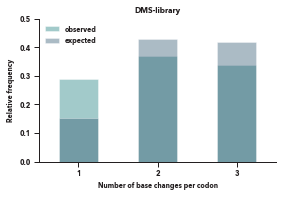

In [ ]:
# ====================== PLOT OBSERVED VS EXPECTED CODON MUTATION TYPES ======================

fig = plt.figure(figsize=(wi*0.6, hi/3))

sns.barplot(relative_Nt_changes_observed, alpha = 0.5, label = "observed", color = "#38A3A5", width = 0.5)
sns.barplot(relative_expected_Nt_changes, alpha = 0.4, label = "expected", color = "#22577A", width = 0.5)
plt.legend(frameon = False)
plt.xlabel("Number of base changes per codon")
plt.ylabel("Relative frequency")
plt.title("DMS-library")
plt.ylim(top = 0.50)
plt.savefig(f"{FigFolder}/{variant}_base_changes_per_codon_exp_vs_obs.pdf")
plt.show()